In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
x, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

cuda


/home/e.gemmell/neural_net_toys/venv/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784) (70000,)


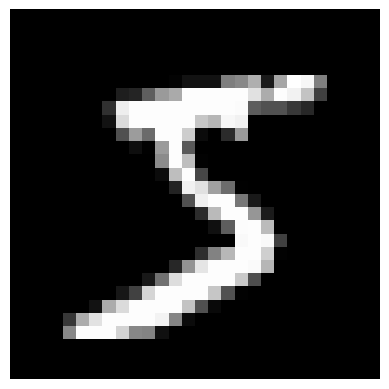

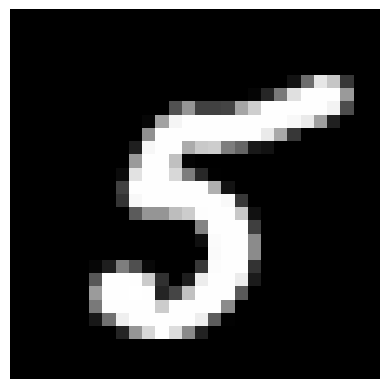

In [2]:
class MnistDataset(torch.utils.data.Dataset):
    def __init__(self, data,targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        slice_i = slice_i = torch.tensor(self.data[idx], dtype=torch.float32)
        target = self.targets[idx]
        return slice_i,target

def show_bw_image(img_array):
    plt.imshow(img_array.reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.show()

X = x/255
Y = np.array([int(num) for num in y])
# print(type(Y),type(Y[0]))
train_dataset = MnistDataset(X[:63000],Y[:63000])
val_dataset = MnistDataset(X[63000:],Y[63000:])
show_bw_image(train_dataset[0][0])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
show_bw_image(next(iter(train_loader))[0][0])
# data, target = next(iter(train_loader))
# print("data",data,"target",target)

pred torch.Size([1]) tensor([0])
input_image 9


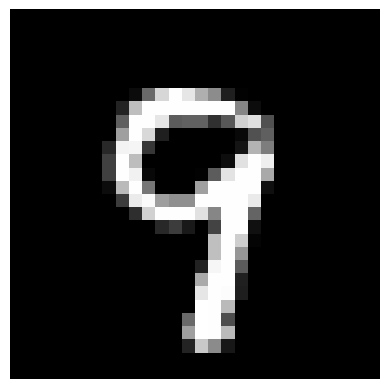

predicted_image tensor([0])


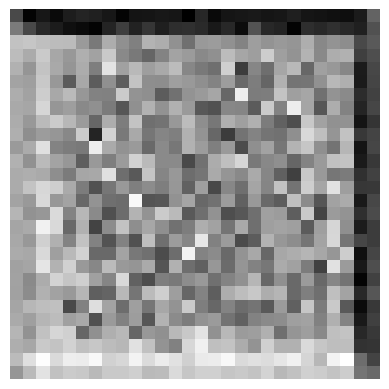

epoch 0,accuracy 0.839, validation loss 1.8481765963814476, train loss 2.195880074654856
epoch 1,accuracy 0.8894285714285715, validation loss 1.68023921251297, train loss 1.8202145291912941
epoch 2,accuracy 0.9067142857142857, validation loss 1.6344817172397266, train loss 1.7275216079527331
epoch 3,accuracy 0.9178571428571428, validation loss 1.6119688456708734, train loss 1.6863157710721415
epoch 4,accuracy 0.9234285714285714, validation loss 1.5964853741905907, train loss 1.6613629979472007
epoch 5,accuracy 0.927, validation loss 1.5874099471352316, train loss 1.6446826804068782
epoch 6,accuracy 0.934, validation loss 1.5797967943278226, train loss 1.6323666668707324
epoch 7,accuracy 0.9368571428571428, validation loss 1.5738977551460267, train loss 1.6215150836975343
epoch 8,accuracy 0.9402857142857143, validation loss 1.5700862667777322, train loss 1.614641099206863
epoch 9,accuracy 0.9427142857142857, validation loss 1.5660860993645407, train loss 1.6069428824609326
epoch 10,accu

KeyboardInterrupt: 

In [21]:
class simple_autoencoder(torch.nn.Module):
    def __init__(self):
        super(simple_autoencoder, self).__init__()

        self.enc_conv1 = nn.Conv2d(1, 32, 3, 1)
        self.enc_conv2 = nn.Conv2d(32, 64, 3, 1)
        self.enc_dropout1 = nn.Dropout(0.25)
        self.enc_dropout2 = nn.Dropout(0.5)
        self.enc_fc1 = nn.Linear(9216, 128)
        self.enc_fc2 = nn.Linear(128, 10)

        self.dec_fc1 = nn.Linear(10,128)
        self.dec_fc2 = nn.Linear(128,9216)
        self.dec_fc3 = nn.Linear(9216,30976)
        self.dec_dropout1 = nn.Dropout(0.5)
        self.dec_dropout2 = nn.Dropout(0.25)
        self.dec_dropout3 = nn.Dropout(0.25)
        self.dec_deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1)
        self.dec_deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1)
        self.dec_deconv3 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1)


        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.dis_conv1 = nn.Conv2d(1, 32, 3, 1)
        self.dis_conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dis_dropout1 = nn.Dropout(0.25)
        self.dis_dropout2 = nn.Dropout(0.5)
        self.dis_fc1 = nn.Linear(9216, 128)
        self.dis_fc2 = nn.Linear(128, 1)

    def encoder(self,input):
        x = input.view(-1,1,28,28)
        # print(x.shape)
        x = self.enc_conv1(x) # now a (batch_size, 32, 26, 26) sized tensor
        # print(x.shape)
        x = F.relu(x)
        x = self.enc_conv2(x) # now a (batch_size, 64,24,24) sized tensor
        # print(x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)# now a (batch_size, 64,12,12) sized tensor
        # print(x.shape)
        x = self.enc_dropout1(x)
        x = torch.flatten(x, 1)# now a 9216
        # print(x.shape)
        x = self.enc_fc1(x)
        x = F.relu(x)
        x = self.enc_dropout2(x)
        x = self.enc_fc2(x)
        # print(x.shape)
        latent = F.sigmoid(x)
        return latent

    def decoder(self, latent):
        # print("decoder")
        x = self.dec_fc1(latent)
        # print(x.shape)
        x = F.relu(x)
        x = self.dec_dropout1(x)
        x = self.dec_fc2(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.dec_dropout2(x)
        x = self.dec_fc3(x)
        x = F.relu(x)
        x = self.dec_dropout3(x)
        x = x.view(-1,64,22,22)
        # print(x.shape)
        x = self.dec_deconv1(x)
        x = F.relu(x)
        x = self.dec_deconv2(x)
        x = F.relu(x)
        x = self.dec_deconv3(x)
        x = F.sigmoid(x)
        x = torch.flatten(x,1)
        return x


        
    def forward(self, input):
        
        latent = self.encoder(input)
        x = self.decoder(latent)

        return latent, x

    def generate_image_from_one_hot(self,latent):
        return self.decoder(latent)

def visualise_prediction(model, batch,index = 0):
    data,label = batch
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient tracking for efficiency
        input_cpu = torch.tensor(np.expand_dims(data, axis=0), dtype=torch.float32)
        input = input_cpu.to(device)
        # input = data
        # print("input",input.shape,input)
        # predicted_output,pred_label = model(input)
        pred_label, predicted_image = model(input)
        pred_label = pred_label.cpu().argmax(dim=1)
        predicted_image = predicted_image.cpu()
        # predicted_output = predicted_output.numpy()[0]
        print("pred",pred_label.shape,pred_label)
        print("input_image", label)
        show_bw_image(input_cpu)

        print("predicted_image", pred_label)
        show_bw_image(predicted_image)

def generate_image_from_one_hot(model, number = None,one_hot = None):
    if number or number == 0:
            print(f"generating image for number {number}")
            one_hot = [0] * 10
            one_hot[number] = 1
    one_hot = torch.tensor(one_hot, dtype=torch.float32)
    # print("onehot",type(one_hot),one_hot.shape)
    model.eval()
    with torch.no_grad():
        predicted_output = model.generate_image_from_one_hot(one_hot)
        predicted_output = predicted_output.numpy()
        print(predicted_output.shape)
        show_bw_image(predicted_output)
        
def plot_losses(val_losses,train_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def Validate(model, val_loader):
    MSE_loss = nn.MSELoss()
    CE_loss = nn.CrossEntropyLoss()
    model.eval()
    losses = []
    correct_guesses = 0
    total_guesses = 0
    with torch.no_grad():
        for batch in val_loader:
            input_cpu,target = batch
            input = input_cpu.to(device)
            one_hot_target = F.one_hot(target, num_classes=10).float().to(device)
            latent, output = model(input)
            latent = latent
            output = output
            # print("latent shape",latent.shape)
            # print("latent argax", latent.argmax(axis = 1))
            
            for i, pred in enumerate(latent.argmax(axis = 1)):
                if pred == target[i]:
                    correct_guesses += 1
                total_guesses += 1
            mse_loss = MSE_loss(output, input)
            ce_loss = CE_loss(latent, one_hot_target)
            loss = ce_loss+mse_loss
            losses.append(loss.cpu().item())
    # print("total",total_guesses, "correct", correct_guesses)
    return np.mean(losses), (correct_guesses/total_guesses)
    
def Train(model,train_loader, val_loader, epochs,lr):
    MSE_loss = nn.MSELoss()
    CE_loss = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    gradients = []
    epoch_val_losses = []
    epoch_train_losses = []
    epoch_val_accuracies = []
    for epoch in range(epochs):
        model.train()
        losses = []
        for i,batch in enumerate(train_loader):
            # print("batch",i)
            input,target = batch
            input = input.to(device)
            targets = target.to(device)
            # print("input",input.shape)
            # print("target", type(target))
            target = F.one_hot(target, num_classes=10).float().to(device)

            optimizer.zero_grad() #sets initial gradients to 0 for security purposes
        
            # output, latent = model(input)
            latent, output = model(input)
            # print("latent",latent.shape,"target",target.shape)
            mse_loss = MSE_loss(output, input)
            ce_loss = CE_loss(latent, target)

            loss = ce_loss+mse_loss
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        val_loss,val_accuracy = Validate(model, val_loader)
        epoch_val_accuracies.append(val_accuracy)
        epoch_val_losses.append(val_loss)
        epoch_train_losses.append(np.mean(losses))
        # print('epoch {}, loss {}'.format(epoch, loss.item()))
        print(f'epoch {epoch},accuracy {val_accuracy}, validation loss {epoch_val_losses[-1]}, train loss {epoch_train_losses[-1]}')

    plot_losses(epoch_val_losses,epoch_train_losses)  


    
learning_rate = 0.0001
num_epochs = 100

model = simple_autoencoder().to(device)
visualise_prediction(model,val_dataset[random.randrange(10)])
# generate_image_from_one_hot(model,number = 0)
Train(model,train_loader, val_loader, num_epochs,learning_rate)
visualise_prediction(model,val_dataset[random.randrange(10)])
# generate_image_from_one_hot(model,number = 0)


/tmp/ipykernel_1051605/4293354412.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interp = torch.tensor(interp.unsqueeze(0), dtype=torch.float32).to(device)


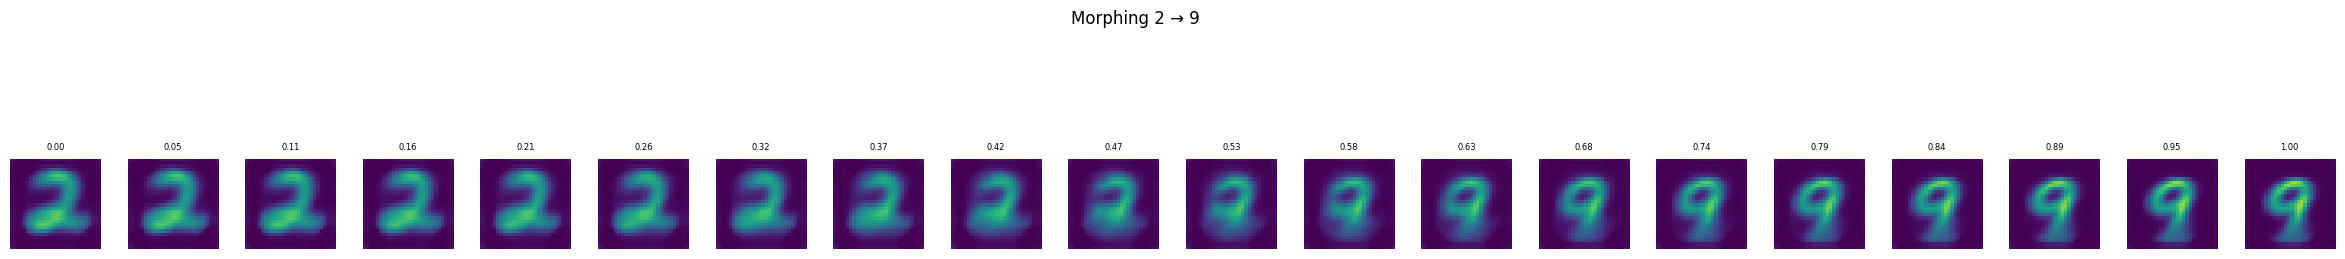

In [29]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def morph_in_grid(model, class_from, class_to, steps=20):
    # One-hot vectors
    model.eval()
    vec_from = torch.zeros(10)
    vec_from[class_from] = 1.0

    vec_to = torch.zeros(10)
    vec_to[class_to] = 1.0

    fig, axes = plt.subplots(1, steps, figsize=(steps * 1.5, 4))
    with torch.no_grad():
      for i in range(steps):
          alpha = i / (steps - 1)
          interp = (1 - alpha) * vec_from + alpha * vec_to
          interp = torch.tensor(interp.unsqueeze(0), dtype=torch.float32).to(device)
          with torch.no_grad():
              output = model.decoder(interp).cpu().numpy().reshape(28, 28)
          axes[i].imshow(output, vmin=0, vmax=1)
          axes[i].axis('off')
          axes[i].set_title(f"{alpha:.2f}", fontsize=6)

    fig.suptitle(f"Morphing {class_from} → {class_to}")
    plt.subplots_adjust(wspace=0.3)
    plt.show()

morph_in_grid(model, class_from=2, class_to=9)


pred torch.Size([1]) tensor([3])
input_image 3


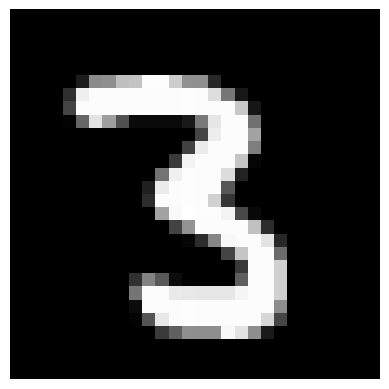

predicted_image tensor([3])


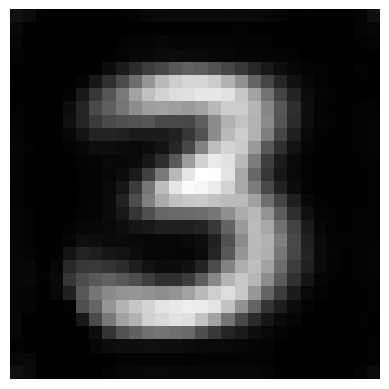

pred torch.Size([1]) tensor([7])
input_image 7


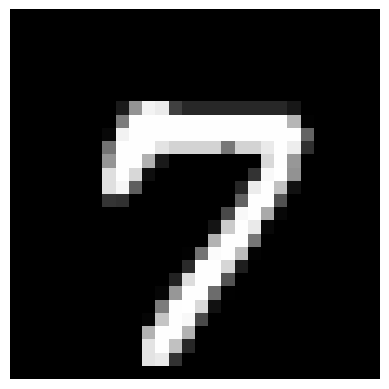

predicted_image tensor([7])


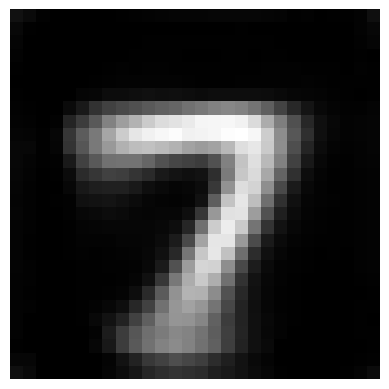

pred torch.Size([1]) tensor([3])
input_image 3


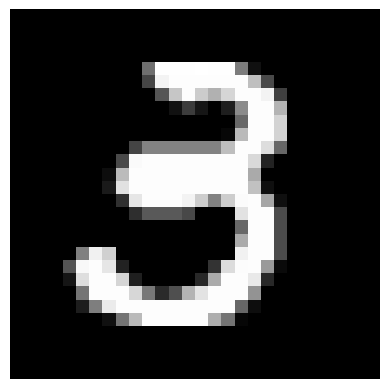

predicted_image tensor([3])


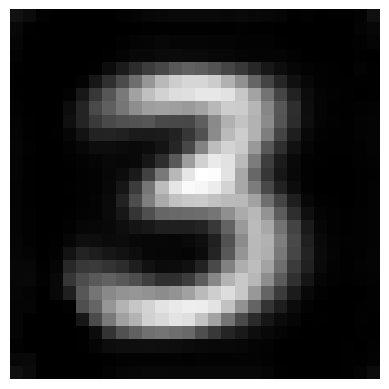

pred torch.Size([1]) tensor([0])
input_image 0


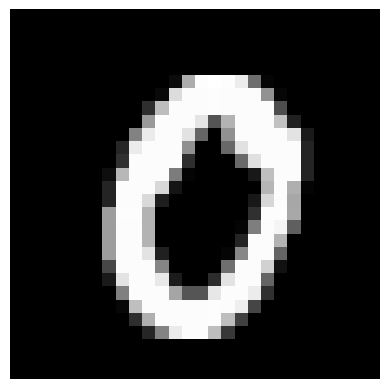

predicted_image tensor([0])


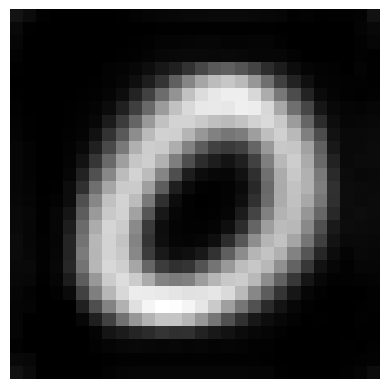

pred torch.Size([1]) tensor([8])
input_image 8


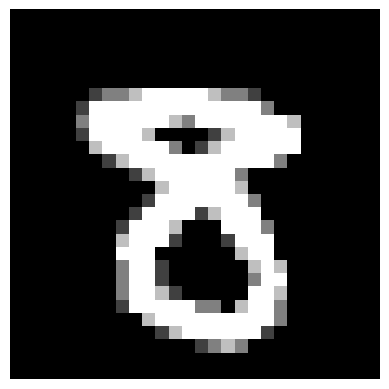

predicted_image tensor([8])


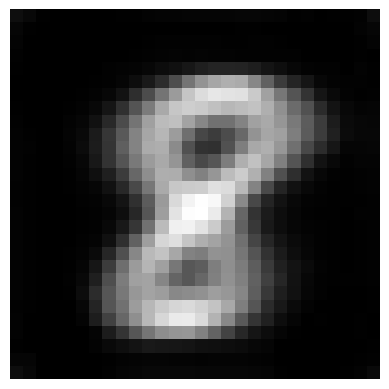

pred torch.Size([1]) tensor([6])
input_image 6


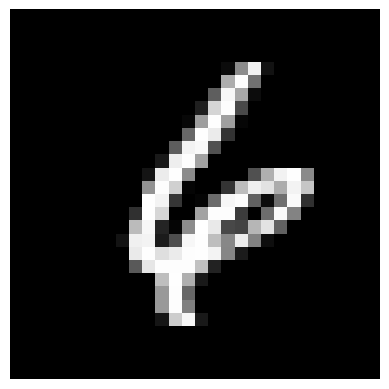

predicted_image tensor([6])


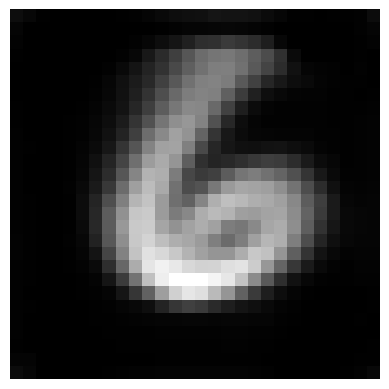

pred torch.Size([1]) tensor([4])
input_image 4


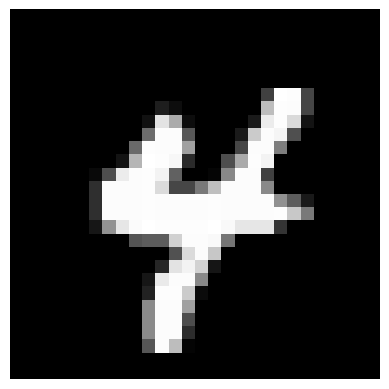

predicted_image tensor([4])


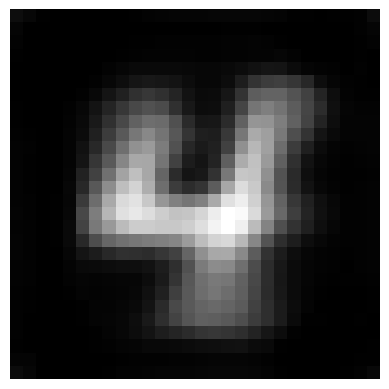

pred torch.Size([1]) tensor([4])
input_image 4


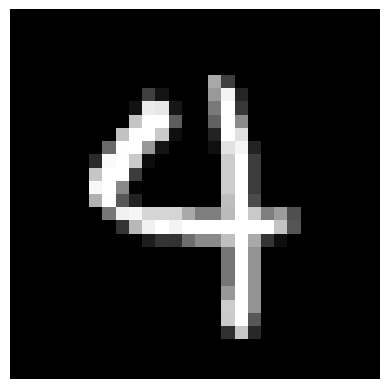

predicted_image tensor([4])


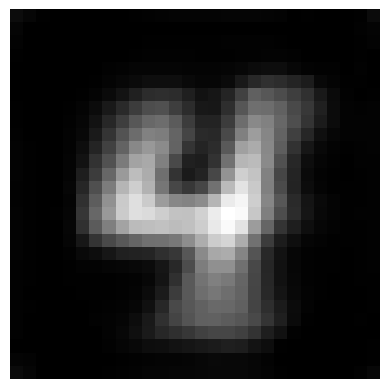

pred torch.Size([1]) tensor([8])
input_image 8


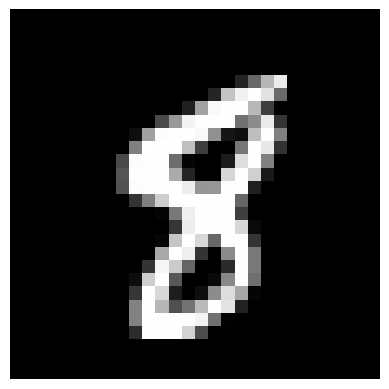

predicted_image tensor([8])


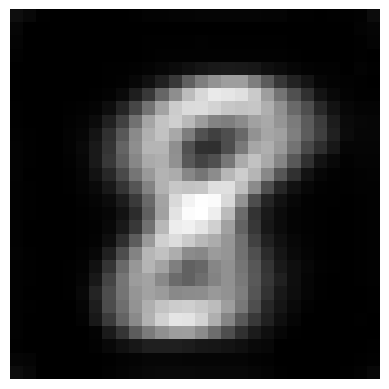

pred torch.Size([1]) tensor([3])
input_image 3


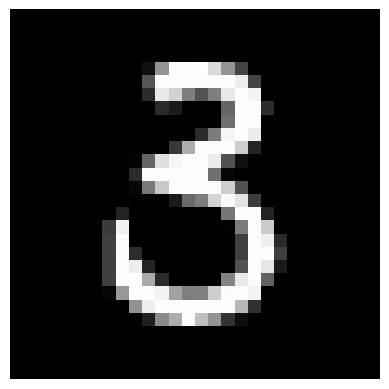

predicted_image tensor([3])


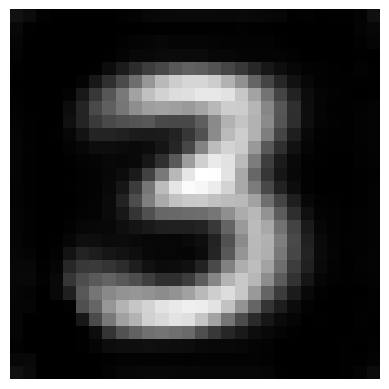

In [30]:
import random

indices = random.sample(range(len(val_dataset)), 10)
for i in indices:
    # print(i)
    # print(val_dataset[i])
    visualise_prediction(model, val_dataset[i])